In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import uproot
import matplotlib as mpl
import math

from scipy.optimize import curve_fit
from scipy import interpolate, special

In [2]:
# MPL config
mpl.rc('font', size=14)

# Plane
IPLANE = 2

dosave = True
savedir = "./Results/100000_Evts/Plane_" + str(IPLANE) + "/"

# Clear figures in main loop
CLEARPLT = True

In [3]:
# Configuration

# Filename for WC configuration containing electron paths
#WCpaths_filename = "./garfield-icarus-fnal-rev1.json"
WCpaths_filename = "./garfield-sbnd-v1.json"

# Time spacing in file
time = np.linspace(0,100,1000, endpoint=False)

# Filename and histogram with electronics response
#fER = "elecResp_ICARUS.root"
#fERh = uproot.open(fER)["ER"]

# Filename with measured signal response
SR_filename = "./WFresults_Plane%i_XX.root" % IPLANE

# Whether to include Guassian broadening in fit
if IPLANE == 2:
    FITGAUS = True
else:
    FITGAUS = False

# Include skew?
FITSKEW = False

# What range of time to fit the response
FIT_PERIOD = 5

# What range of time to plot the response
PLT_PERIOD = 10

# values of thxz
#thxzs = list(range(20, 82, 2)) # 20-80, inclusive
thxzs = list(range(58, 82, 2)) # 30-80, inclusive

# Plot various things
PLTPATHS = True # electron paths
PLTFR = True # field response
PLTSR = True # signal response
PLTFIT = True # fit

# Process the configuration
dt = time[1] - time[0]

thxzlo = thxzs[:-1]
thxzhi = thxzs[1:]

uhf = uproot.open(SR_filename)

#ER_val = fERh.values()
#ER_time = fERh.axis().centers()
#ER = interpolate.interp1d(ER_time, ER_val, kind="linear", bounds_error=False, fill_value=0)

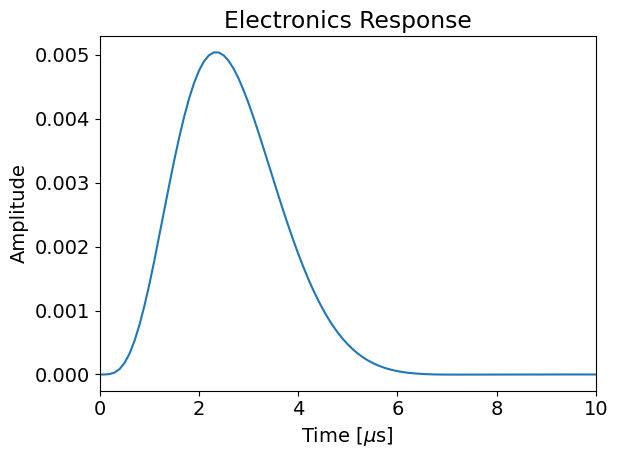

In [4]:
#Parametrised electronics response that returns the values in an array. It requires time and shaping as input
#time = np.arange(0, 50, 0.5) #array of time values from 0 to 50 in 0.5 microsecond increments

shaping = 2 #microseconds

elecResp = [0]*len(time)

gain = 14 * (4096/1800) * 1.60217663e-3#mV/fC * ADC/mV * fC/e- = ADCs/e-

A1 = 4.31054
A2 = 2.6202
A3 = 0.464924
A4 = 0.762456
A5 = 0.327684
Exp1 = 2.94809
Exp2 = 2.82833
Exp3 = 2.40318
lambda1 = 1.19361
lambda2 = 2.38722
lambda3 = 2.5928
lambda4 = 5.18561
for tindex, t in enumerate(time):
    reltime = t / shaping;
    elecResp[tindex] = (A1*gain*math.exp(-Exp1*reltime)) - \
                       ((A2*gain*math.exp(-Exp2*reltime)) * (math.cos(lambda1*reltime) + \
                           (math.cos(lambda1*reltime) * math.cos(lambda2*reltime)) + \
                           (math.sin(lambda1*reltime) * math.sin(lambda2*reltime)))) + \
                       ((A3*gain*math.exp(-Exp3*reltime)) * (math.cos(lambda3*reltime) + \
                           (math.cos(lambda3*reltime) * math.cos(lambda4*reltime)) + \
                           (math.sin(lambda3*reltime) * math.sin(lambda4*reltime)))) + \
                       ((A4*gain*math.exp(-Exp2*reltime)) * (math.sin(lambda1*reltime) - \
                           (math.cos(lambda2*reltime) * math.sin(lambda1*reltime)) + \
                           (math.cos(lambda1*reltime) * math.sin(lambda2*reltime)))) - \
                       ((A5*gain*math.exp(-Exp3*reltime)) * (math.sin(lambda3*reltime) - \
                           (math.cos(lambda4*reltime) * math.sin(lambda3*reltime)) + \
                           (math.cos(lambda3*reltime) * math.sin(lambda4*reltime))))
    
    #elecResp[tindex] = 4.31054 * math.exp(-2.94809 * reltime) * gain - 2.6202 * math.exp(-2.82833 * reltime) * math.cos(1.19361 * reltime) * gain -2.6202 * math.exp(-2.82833 * reltime) *math.cos(1.19361 * reltime) * math.cos(2.38722 * reltime) * gain +0.464924 * math.exp(-2.40318 * reltime) * math.cos(2.5928 * reltime) * gain +0.464924 * math.exp(-2.40318 * reltime) * math.cos(2.5928 * reltime) * math.cos(5.18561 * reltime) * gain +0.762456 * math.exp(-2.82833 * reltime) * math.sin(1.19361 * reltime) * gain -0.762456 * math.exp(-2.82833 * reltime) * math.cos(2.38722 * reltime) * math.sin(1.19361 * reltime) * gain +0.762456 * math.exp(-2.82833 * reltime) * math.cos(1.19361 * reltime) * math.sin(2.38722 * reltime) * gain -2.620200 * math.exp(-2.82833 * reltime) * math.sin(1.19361 * reltime) * math.sin(2.38722 * reltime) * gain -0.327684 * math.exp(-2.40318 * reltime) * math.sin(2.5928 * reltime) * gain +0.327684 * math.exp(-2.40318 * reltime) * math.cos(5.18561 * reltime) * math.sin(2.5928 * reltime) * gain -0.327684 * math.exp(-2.40318 * reltime) * math.cos(2.5928 * reltime) * math.sin(5.18561 * reltime) * gain +0.464924 * math.exp(-2.40318 * reltime) * math.sin(2.5928 * reltime) * math.sin(5.18561 * reltime) * gain

#plt.plot(time, ER(time))
plt.plot(time, elecResp)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude")
plt.xlim([0, 10])
plt.title("Electronics Response")
plt.tight_layout()

if dosave: plt.savefig(savedir + "elecResp.jpeg")

In [5]:
# Helper functions
def convolve(f1, f2):
    '''
    Return the simple convolution of the two arrays using FFT+mult+invFFT method.
    '''
    # fftconvolve adds an unwanted time shift
    #from scipy.signal import fftconvolve
    #return fftconvolve(field, elect, "same")
    s1 = np.fft.fft(f1)
    s2 = np.fft.fft(f2)
    sig = np.fft.ifft(s1*s2)

    return np.real(sig)

def gaus(t, sigma):
    return np.exp(-t**2/(2*sigma**2))

def skewgaus(t, sigma, skew):
    skew = -1/skew
    return gaus(t, sigma)*(1 + special.erf(skew*t/np.sqrt(2)))

def agaus(t, sigmalo, sigmahi):
    return np.exp(-t**2/(2*sigmalo**2))*(t < 0) + np.exp(-t**2/(2*sigmahi**2))*(t >= 0)

def norm(v, vnorm=None):
    if vnorm is None:
        vnorm = v
    if IPLANE == 2:
        return v / vnorm.max()
    else:
        return v / np.abs(vnorm.min())
    
def center(t, v):
    if IPLANE == 0: # Ind-0 -- center on down-peak
        return t - t[np.argmin(v)]
    elif IPLANE == 2: # Collection -- center on peak
        return t - t[np.argmax(v)]
    else: # Ind-1 -- center on zero-cross
        center_ind = np.argmin(np.abs(v[np.argmax(v):np.argmin(v)])) + np.argmax(v)
        return t - t[center_ind]

In [6]:
dat = json.load(open(WCpaths_filename))

driftV = dat["FieldResponse"]["speed"]*1e3 # mm/us

thispaths = dat["FieldResponse"]["planes"][IPLANE]["PlaneResponse"]["paths"]

pitchpos_f = [path["PathResponse"]["pitchpos"] for path in thispaths] # mm

paths_f = [np.array(path["PathResponse"]["current"]["array"]["elements"])
             for path in thispaths]

pitchpos = []
paths = []

for i, (ppos, path) in enumerate(zip(pitchpos_f, paths_f)):
    pitchpos.append(ppos)
    paths.append(path)
    if -ppos not in pitchpos_f:
        pitchpos.append(-ppos)
        paths.append(path)
    # handle boundary between (half-)wires
    else:
        paths[-1] = tuple([paths[-1], paths_f[pitchpos_f.index(-ppos)]])
        
pitchpos, paths = zip(*sorted(zip(pitchpos, paths), key=lambda pair: pair[0]))
pitchpos = np.array(pitchpos)

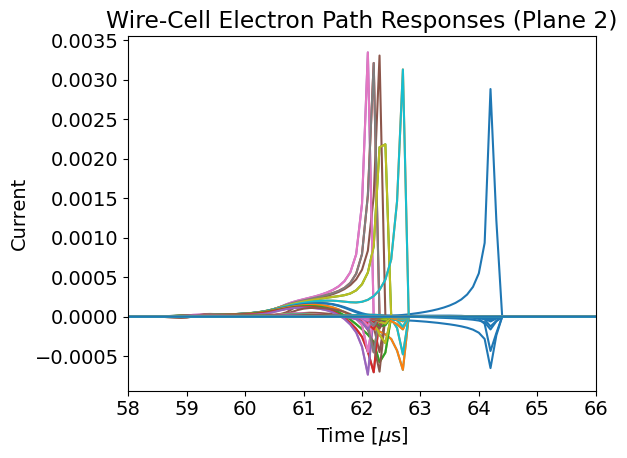

In [7]:
for p, path in zip(pitchpos, paths):
    if isinstance(path, tuple):
        plt.plot(time, -path[0])
    else:
        plt.plot(time, -path)
    
plt.title("Wire-Cell Electron Path Responses (Plane %i)" % IPLANE)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Current")

plt.xlim([58 - 2*(2-IPLANE), 66 - 2*(2-IPLANE)])
plt.tight_layout()

if dosave: plt.savefig(savedir + "pathResp.jpeg")

In [8]:
# interpolate the paths with a finer spacing (0.03mm)
# avoid edge effects by spacing in between the discontinuities in the paths (every 1.5mm)
pitchpos_interp = np.linspace(pitchpos.min(), pitchpos.max(), 2101) + 0.015
paths_interp = []

for i, p in enumerate(pitchpos_interp):
    i_pitchpos = int((p - pitchpos[0]+1e-6) / (pitchpos[1] - pitchpos[0]))
    if i_pitchpos == len(pitchpos) - 1:
        path = paths[i_pitchpos]
    else:
        F1 = paths[i_pitchpos]
        F2 = paths[i_pitchpos+1]
        
        # handle boundary between (half-)wires
        if isinstance(F1, tuple):
            if p > pitchpos[i_pitchpos]:
                F1 = F1[0]
            else:
                F1 = F1[1]
        if isinstance(F2, tuple):
            if p > pitchpos[i_pitchpos+1]:
                F2 = F2[0]
            else:
                F2 = F2[1]
                
        interp = (pitchpos[i_pitchpos+1] - p)/(pitchpos[1] - pitchpos[0])
        path = F1*interp + F2*(1-interp)

    paths_interp.append(path)

In [9]:
if IPLANE == 2:
    txt_x = 0.05
else:
    txt_x = 0.55

In [10]:
nfig = 4
for ith, (thlo, thhi) in enumerate(zip(thxzlo, thxzhi)):
    thmean = (thlo + thhi) / 2.
    
    # Load the measured signal response
    datah = "AnodeRecoHist1D_%ito%i" % (thlo, thhi)
    dataerrh = "AnodeTrackUncertHist2D_%ito%i" % (thlo, thhi)

    hd = uhf[datah]
    hderr = uhf[dataerrh]
    hderr_v = hderr.to_numpy()[0][5]
    hdtime = center(hd.axis().centers(), hd.values())

    hdwhen = np.abs(hdtime) < PLT_PERIOD
    hdfit = np.abs(hdtime) < FIT_PERIOD
    
    # Compute the interpolated field response at this track angle
    thxz = thmean*np.pi/180
    shift = (np.tan(thxz)*pitchpos_interp/driftV/dt).astype(int)

    shifted_paths = []
    for i in range(len(paths_interp)):

        s = shift[i]
        shifted_paths.append(np.roll(paths_interp[i], s))

        if s < 0:
            shifted_paths[i][s:] = 0
        if s > 0:
            shifted_paths[i][:s] = 0
      
    if PLTPATHS:
        plt.figure(ith*nfig)
        for path in shifted_paths:
            plt.plot(time, -path)

        plt.xlim([52.5 - 2*(2-IPLANE), 72.5 - 2*(2-IPLANE)])
        plt.xlabel("Time [$\\mu$s]")
        plt.ylabel("Amplitude")
        plt.title("Interpolated Electron Path Response (Plane %i)" % IPLANE)
        plt.text(txt_x, 0.8, "$%i^\\circ < \\theta_{xz} < %i^\\circ$" % (thlo, thhi),
            fontsize=16, transform=plt.gca().transAxes)
        plt.tight_layout()
        if dosave: plt.savefig(savedir + "interpPathResp_th%ito%i.jpeg" % (thlo, thhi))
            
    field_response = -sum(shifted_paths)
    
    if PLTFR:
        plt.figure(ith*nfig+1)
        
        plt.plot(time, field_response)
        plt.xlim([52.5 - 2*(2-IPLANE), 72.5 - 2*(2-IPLANE)])
        plt.xlabel("Time [$\\mu$s]")
        plt.ylabel("Amplitude")
        plt.title("Field Response (Plane %i)" % IPLANE)
        plt.text(txt_x, 0.8, "$%i^\\circ < \\theta_{xz} < %i^\\circ$" % (thlo, thhi),
            fontsize=16, transform=plt.gca().transAxes)
        plt.tight_layout()
        if dosave: plt.savefig(savedir + "fieldResp_th%ito%i.jpeg" % (thlo, thhi))
            
    SR = convolve(field_response, elecResp)
    timeplt = center(time, SR)
    
    if PLTSR:
        plt.figure(ith*nfig+2)

        plt.plot(timeplt, SR)
        plt.xlim([-10, 10])
        plt.xlabel("Time [$\\mu$s]")
        plt.ylabel("Amplitude")
        plt.title("Signal Response (Plane %i)" % IPLANE)
        plt.text(txt_x, 0.8, "$%i^\\circ < \\theta_{xz} < %i^\\circ$" % (thlo, thhi),
            fontsize=16, transform=plt.gca().transAxes)
        plt.tight_layout()
        if dosave: plt.savefig(savedir + "signalResp_th%ito%i.jpeg" % (thlo, thhi))
            
    if FITGAUS and FITSKEW:
        def fitfun(t, sigmalo, sigmahi, mu):
            resp = norm(convolve(SR, agaus(time - time.max()/2, sigmalo, sigmahi)))
            resp_interp = interpolate.interp1d(timeplt + mu + time.max()/2, resp, 
                                               kind="linear", bounds_error=False, fill_value=0)
            return resp_interp(t)
        
        p0 = [0.5, 1, 0]
        popt, perr = curve_fit(fitfun, hdtime[hdfit], norm(hd.values()[hdfit]),
                              p0, norm(hderr_v[hdfit], hd.values()), True, maxfev=int(1e6))

        fitsigmalo = np.abs(popt[0])
        fitsigmahi = np.abs(popt[1])
        fitmu = popt[2]
    elif FITGAUS:
        def fitfun(t, sigma, mu):
            resp = norm(convolve(SR, gaus(time, sigma)))
            resp_interp = interpolate.interp1d(timeplt+mu, resp, 
                                               kind="linear", bounds_error=False, fill_value=0)
            return resp_interp(t)
        p0 = [0.5, 0]
        bounds = (
            [0.1, -4],
            [5, 4]
        )
        popt, perr = curve_fit(fitfun, hdtime[hdfit], norm(hd.values()[hdfit]),
                              p0, norm(hderr_v[hdfit], hd.values()), True, bounds=bounds)

        fitsigma = np.abs(popt[0])
        fitmu = popt[1]  
    else:
        def fitfun(t, mu):
            resp_interp = interpolate.interp1d(timeplt + mu, norm(SR), 
                                               kind="linear", bounds_error=False, fill_value=0)
            return resp_interp(t)
        p0 = [0]
        popt, perr = curve_fit(fitfun, hdtime[hdfit], norm(hd.values()[hdfit]),
                              p0, norm(hderr_v[hdfit], hd.values()), True)

        fitsigma = 0
        fitmu = popt[0]
        
    if PLTFIT:
        fig, (ax1, ax2) = plt.subplots(num=ith*nfig+3, figsize=(6.4, 5.6),
                                       nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})


        ax1.errorbar(hdtime[hdwhen], norm(hd.values()[hdwhen]),
                     norm(hderr_v[hdwhen], hd.values()), linestyle="none", marker=".",
                color="black", label="Calibrated Response")

        if FITGAUS:
            ax1.plot(timeplt, norm(SR), label="Toy Response")
            if FITSKEW:
                label = "Toy Response $\\circledast$\n$\\mathcal{SG}(\\sigma_{lo}=%.2f\mu s, \\sigma_{hi} = %.2f)$" % (fitsigmalo, fitsigmahi)
            else:
                label = "Toy Response $\\circledast$\n$\\mathcal{G}(\\sigma=%.2f\mu s)$" % fitsigma
            ax1.plot(hdtime, fitfun(hdtime, *popt), label=label)
            
            ax1.legend(ncol=2 ,loc='upper center', bbox_to_anchor=(0.5, 1.55))
        else:
            ax1.plot(timeplt+fitmu, norm(SR), label="Toy Response")
            ax1.legend(ncol=2 ,loc='upper center', bbox_to_anchor=(0.5, 1.2))

        fit = fitfun(hdtime[hdwhen], *popt)

        ax2.errorbar(hdtime[hdwhen], norm(hd.values()[hdwhen])/fit,
                     norm(hderr_v[hdwhen], hd.values())/fit,
                    linestyle="none", marker=".", color="black")

        ax2.set_ylim([0.9, 1.1])
        ax2.axhline(1, color="r")

        plt.xlim([-10, 10])
        plt.subplots_adjust(hspace=0)
        plt.title("Response Fit (Plane %i)" % IPLANE)

        ax2.set_xlabel("Time [$\\mu$s]")
        ax1.set_ylabel("Amp. Normalized")
        ax1.text(txt_x, 0.8, "$%i^\\circ < \\theta_{xz} < %i^\\circ$" % (thlo, thhi),
                 fontsize=16, 
                transform=ax1.transAxes)
        ax2.set_ylabel("Data / Fit", fontsize=12)
        
        plt.tight_layout()
        if dosave: plt.savefig(savedir + "toyFit_th%ito%i.jpeg" % (thlo, thhi))
            
    if CLEARPLT: plt.close("all")